In [112]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from statsmodels.api import OLS, add_constant
from statsmodels.tsa.stattools import adfuller

### Cointégration
Deux séries temporelles sont cointégrées si elles partagent une tendance stochastique commune.

Si on a deux séries temporelles $ x_t $ et $ y_t $, elles sont cointégrées d'ordre $ d,b $ si elles sont intégrées d'ordre $ d $ et que la combinaison linéaire suivante est intégrée d'ordre $ d - b $ :

$$ \epsilon_t = y_t - (\alpha + \beta x_t) $$

ou $ \alpha $ et $ \beta $ sont des paramètres estimés à partir d'une régression linéaire

In [ ]:
tickers = ['GDX', 'GOAU']
prices = yf.download(tickers).dropna()
prices

Text(0.5, 1.0, 'GDX vs Gold Future')

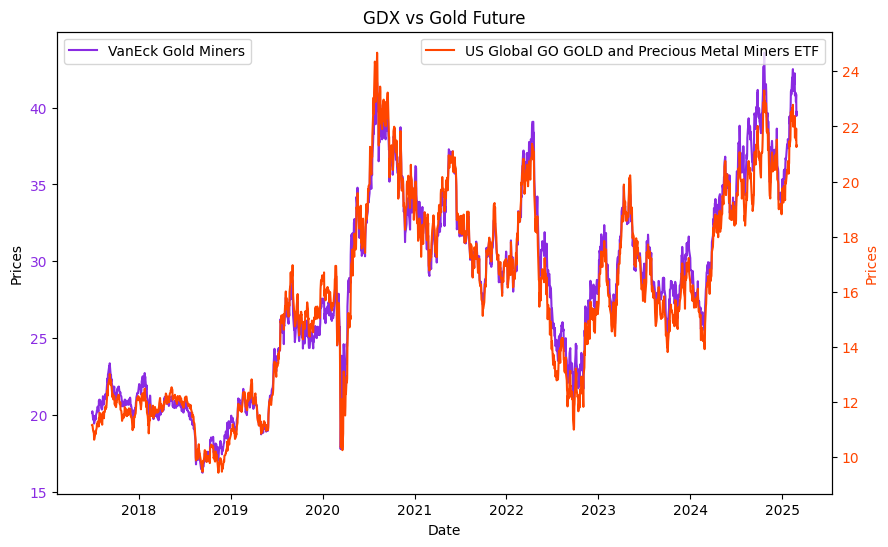

In [114]:
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(prices['Close']['GDX'], color = 'blueviolet', label = 'VanEck Gold Miners')
ax1.set_xlabel("Date")
ax1.set_ylabel("Prices")
ax1.tick_params(axis = 'y', labelcolor = 'blueviolet')
ax1.legend(loc= 'upper left')

ax2 = ax1.twinx()
ax2.plot(prices['Close']['GOAU'], color = 'orangered', label = 'US Global GO GOLD and Precious Metal Miners ETF')
ax2.set_ylabel("Prices", color = 'orangered')
ax2.tick_params(axis = 'y', labelcolor = 'orangered')
ax2.legend(loc= 'upper right')

plt.title('GDX vs Gold Future')

In [115]:
X = add_constant(prices['Close']['GOAU'])
y = prices['Close']['GDX']

In [116]:
model = OLS(endog = y, exog = X)
res = model.fit()
res.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    GDX   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                 8.199e+04
Date:                Sun, 02 Mar 2025   Prob (F-statistic):               0.00
Time:                        16:50:53   Log-Likelihood:                -2647.6
No. Observations:                1928   AIC:                             5299.
Df Residuals:                    1926   BIC:                             5310.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1054      0.101     -1.042      0.298      -0.304       0.093
GOAU           1.7825      0.006    286.346      0.000       1.770       1.795
==============================================================================
Omnibus:                       35.363   Durbin-Watson:                   0.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.827
Skew:                           0.250   Prob(JB):                     2.02e-07
Kurtosis:                       2.635   Cond. No.                         75.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### $ \epsilon_t $ est une série temporelle. Ce sont les résidus de notre régression linéaire. Si ces résidus sont stationnaires, alors nos deux séries temporelles sont cointégrées.

In [ ]:
epsilon = prices['Close']['GDX'] - (res.params[0] + res.params[1] * prices['Close']['GOAU'])

adf = adfuller(epsilon, autolag= 'AIC', regression = 'C')

In [118]:
print(f'ADF statistic : {adf[0]}')
print(f'ADF p_value : {adf[1]}')

ADF statistic : -3.8010945310437863
ADF p_value : 0.002896136340498282


#### La valeur de p est faible, donc on peut rejeter l'hypothèse nulle, donc la série est probablement stationnaire.

Text(0, 0.5, 'Epsilon')

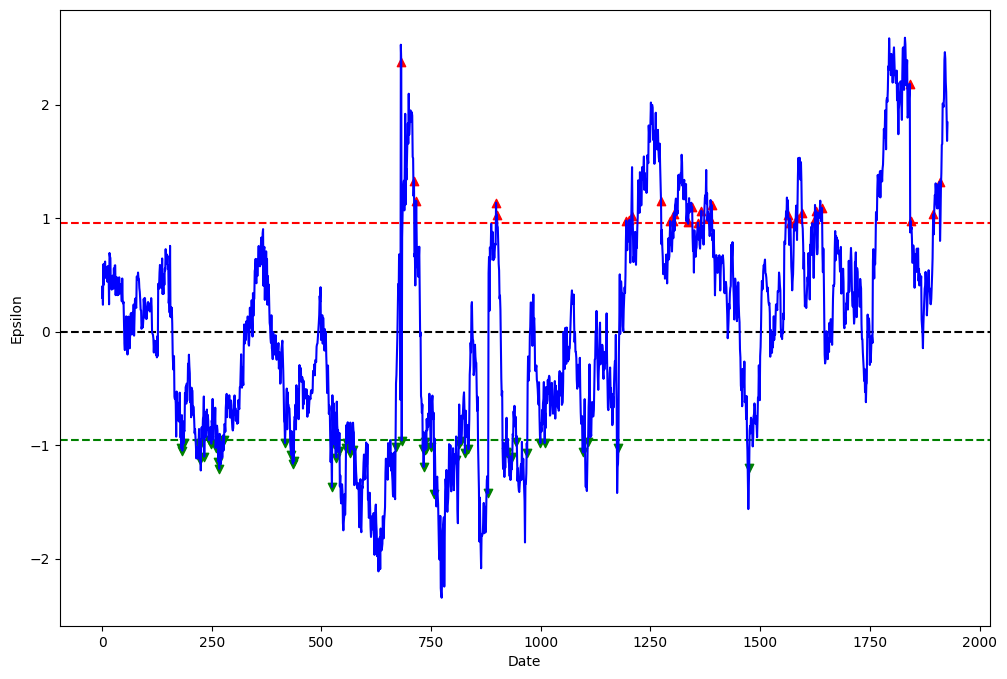

In [119]:
np_epsilon = np.array(epsilon)

mean_epsilon = np.mean(np_epsilon)
std_epsilon = np.std(np_epsilon)

plt.figure(figsize = (12, 8))

plt.axhline(mean_epsilon, color='black', linestyle='dashed')
plt.axhline(mean_epsilon + std_epsilon, color='red', linestyle='dashed')
plt.axhline(mean_epsilon - std_epsilon, color='green', linestyle='dashed')

above = np.where(np_epsilon > mean_epsilon + std_epsilon)
below = np.where(np_epsilon < mean_epsilon - std_epsilon)

below = (below[0][:-1][(below[0][1:] != below[0][:-1] + 1)])
above = (above[0][:-1][(above[0][1:] != above[0][:-1] + 1)])

plt.scatter(above, np_epsilon[above], color="red", marker="^")
plt.scatter(below, np_epsilon[below], color="green", marker="v")

plt.plot(np_epsilon, color="blue")
plt.xlabel('Date')
plt.ylabel('Epsilon')

In [120]:
returns = prices['Close'].pct_change()
returns.dropna()
returns = returns.drop(index = returns.index[0])

hedge_ratio = sp.stats.pearsonr(returns['GDX'], returns['GOAU'])[0] * np.std(returns['GDX']) / np.std(returns['GOAU'])

In [121]:
portfolio_cumret = np.cumsum(returns['GDX'] - hedge_ratio * returns['GOAU'])
portfolio_ret = returns['GDX'] - hedge_ratio * returns['GOAU']

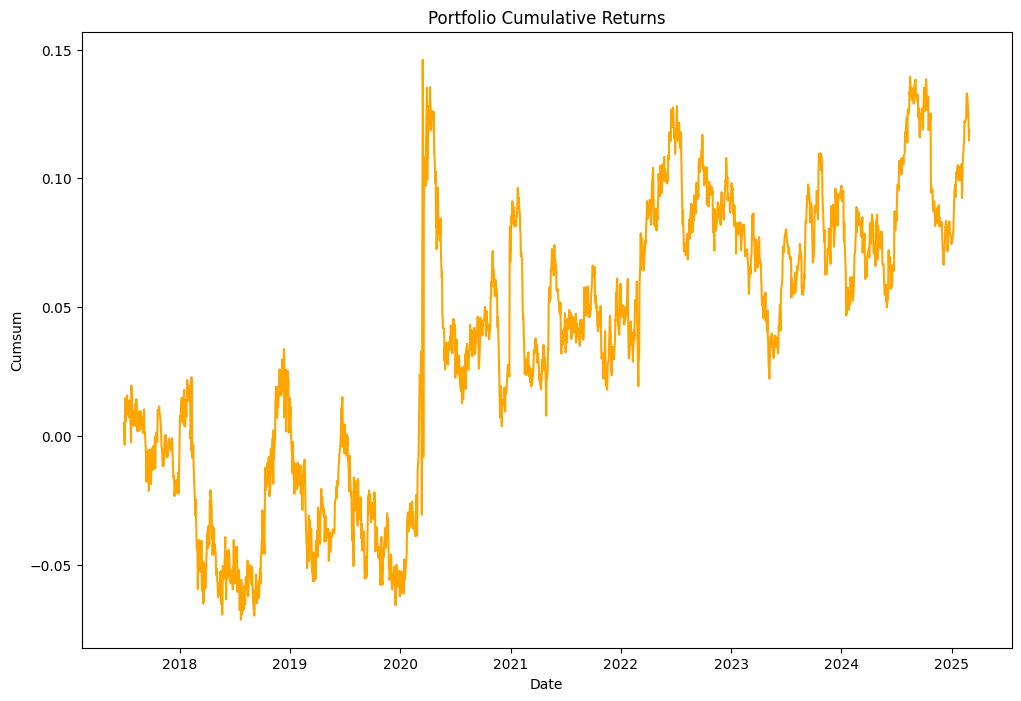

In [122]:
plt.figure(figsize=(12, 8))
plt.plot(portfolio_cumret, color='orange')
plt.title('Portfolio Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumsum')

plt.show()

In [123]:
short = pd.Series(np.where(epsilon > mean_epsilon + std_epsilon, -1, 0), index=epsilon.index)
long = pd.Series(np.where(epsilon < mean_epsilon - std_epsilon, 1, 0), index=epsilon.index)
pos = long + short

pos = pos.apply(lambda x: np.where(x == 0, np.nan, x)).fillna(method='ffill').fillna(0)
backtest_ret = portfolio_ret * pos[:-1]

C:\Users\Romain\AppData\Local\Temp\ipykernel_12720\224180797.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pos = pos.apply(lambda x: np.where(x == 0, np.nan, x)).fillna(method='ffill').fillna(0)


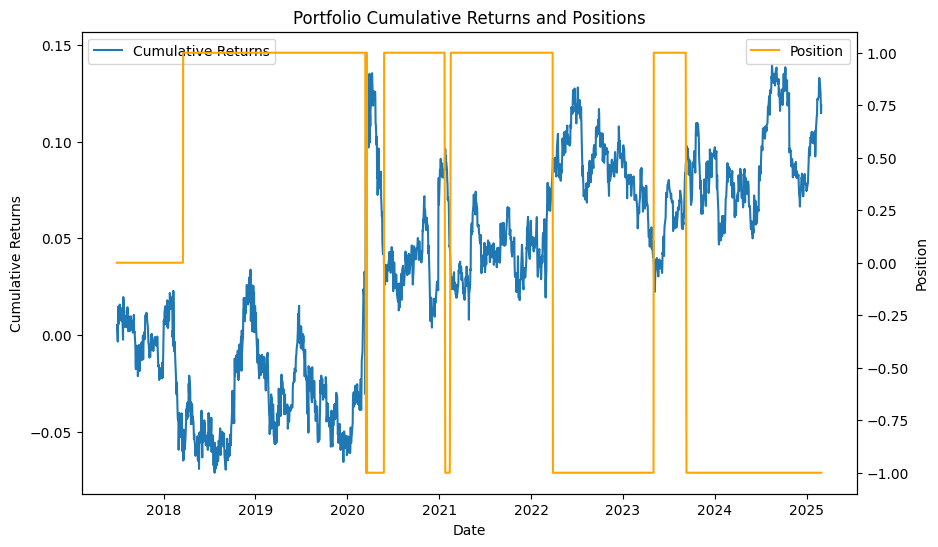

In [124]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(portfolio_cumret, label='Cumulative Returns')
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Returns')
ax1.legend(loc='upper left')
ax1.set_title('Portfolio Cumulative Returns and Positions')

ax2 = ax1.twinx()
ax2.plot(pos, color='orange', label='Position')
ax2.set_ylabel('Position')
ax2.legend(loc='upper right')
plt.show()

#### La crise du covid a eu un effet très négatif sur nos returns car nous avons pris des positions à l'inverse de celles que nous aurions du prendre. Afin de réduire ce genre de risques, il peut être intéressant d'implémenter d'autres modèles, comme les modèles de Markov cachés (HMM)

Text(0, 0.5, 'Cumsum')

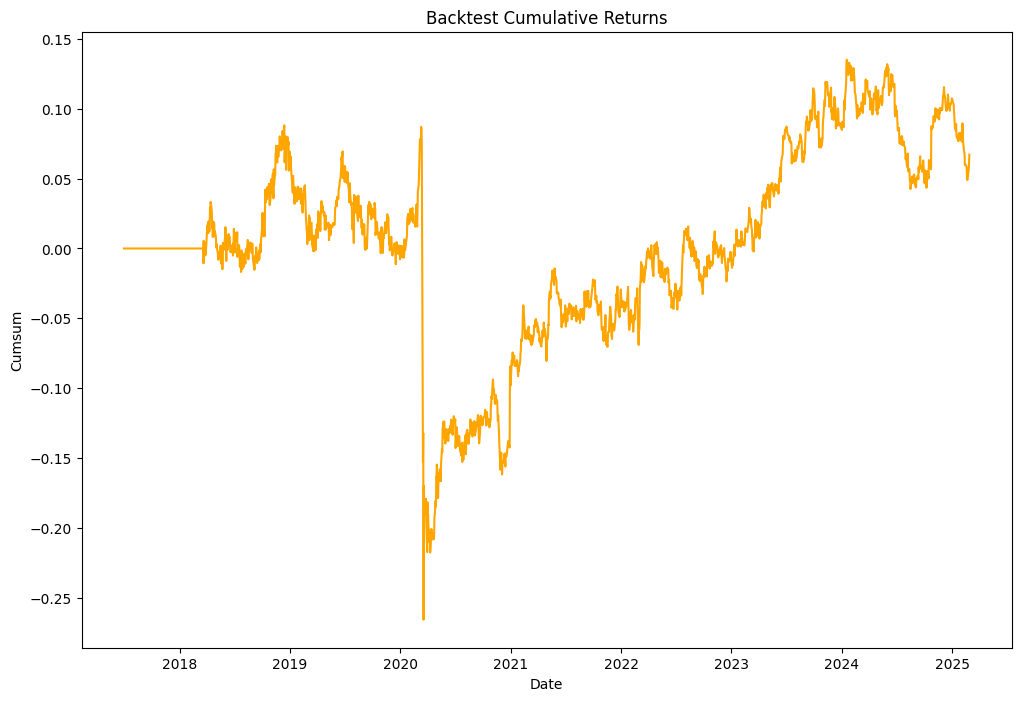

In [125]:
plt.figure(figsize=(12, 8))
plt.plot(backtest_ret.cumsum(), color='orange')
plt.title('Backtest Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumsum')